**This project focuses on detecting and recognizing car number plates using PyTorch, YOLOv8n, and OCR. Begin by setting up the environment with the necessary libraries, such as PyTorch, YOLOv8, and an OCR tool like Tesseract. Load a dataset of car images with annotated number plates for training. The YOLOv8n model is fine-tuned to detect number plates, and after training, it’s used to identify plates in new images.**

**Once a number plate is detected, OCR is applied to extract and process the text. The results, including detected bounding boxes and recognized text, are visualized, and the model’s performance is evaluated. The notebook provides all the necessary steps to replicate this process and explore the effectiveness of the model for number plate recognition.**

# Importing PyTorch and check cuda

In [1]:
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import torch

print(f'{torch.cuda.is_available() = }')
print(f'{torch.cuda.device_count() = }')

torch.cuda.is_available() = True
torch.cuda.device_count() = 2


In [2]:
!pip install ultralytics

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.0/1.0 MB 16.1 MB/s eta 0:00:00


In [3]:
!pip install -U ipywidgets

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 139.8/139.8 kB 3.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 216.6/216.6 kB 6.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 39.7 MB/s eta 0:00:00
  Attempting uninstall: widgetsnbextension
    Found existing installation: widgetsnbextension 3.6.7
    Uninstalling widgetsnbextension-3.6.7:
      Successfully uninstalled widgetsnbextension-3.6.7
  Attempting uninstall: jupyterlab_widgets
    Found existing installation: jupyterlab-widgets 3.0.9
    Uninstalling jupyterlab-widgets-3.0.9:
      Successfully uninstalled jupyterlab-widgets-3.0.9
  Attempting uninstall: ipywidgets
    Found existing installation: ipywidgets 7.7.1
    Uninstalling ipywidgets-7.7.1:
      Successfully uninstalled ipywidgets-7.7.1


In [4]:
dataset_path = '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations'

# Extracting digits from file name

In [5]:
import re

def the_number_in_the_string(filename):
    match = re.search(r'(\d+)', filename)
    
    if match:
        return int(match.group(0))
    else:
        return 0

In [6]:
print(the_number_in_the_string("file123.txt"))  
print(the_number_in_the_string("no_numbers"))

123
0


# Formatting the XML File and creating DF

In [7]:
#to store labels and image info
labels_dict = dict(
    img_path=[], 
    xmin=[], 
    xmax=[], 
    ymin=[], 
    ymax=[], 
    img_w=[], 
    img_h=[]
)

In [8]:
labels_dict

{'img_path': [],
 'xmin': [],
 'xmax': [],
 'ymin': [],
 'ymax': [],
 'img_w': [],
 'img_h': []}

In [9]:
import os
from glob import glob

#get XML files from the annotations dir
xml_files = glob(f'{dataset_path}/Annotations/*.xml')
xml_files

['/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v05_032250.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v04_020400.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v07_019475.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v08_036575.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v02_001875.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v06_042425.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v08_023925.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v03_056725.xml',
 '/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/Annotations/v04_013550.xml',
 '/kaggle/input/surgerical-t

In [10]:
import xml.etree.ElementTree as xet

In [11]:
import os
import cv2
import pandas as pd
import shutil
import xml.etree.ElementTree as xet
from tqdm import tqdm

class_dict = {
    0: "Bipolar",
    1: "SpecimenBag",
    2: "Grasper",
    3: "Irrigator",
    4: "Scissors",
    5: "Hook",
    6: "Clipper"
}

name_to_id = {v: k for k, v in class_dict.items()}

labels_dict = {
    'img_path': [],
    'img_id': [],
    'xmin': [],
    'xmax': [],
    'ymin': [],
    'ymax': [],
    'img_w': [],
    'img_h': [],
    'class_id': []
}

for filename in tqdm(sorted(xml_files, key=the_number_in_the_string)):
    info = xet.parse(filename)
    root = info.getroot()

    img_name = root.find('filename').text
    img_id, _ = os.path.splitext(img_name)
    img_path = os.path.join(dataset_path, 'JPEGImages', img_name)

    image = cv2.imread(img_path)
    if image is None:
        print(f"Warning: Image not found - {img_path}")
        continue
    height, width, _ = image.shape

    for member_object in root.findall('object'):
        class_name = member_object.find('name').text
        if class_name not in name_to_id:
            print(f"Warning: Unknown class '{class_name}' in {filename}")
            continue
        class_id = name_to_id[class_name]

        labels_info = member_object.find('bndbox')
        xmin = int(labels_info.find('xmin').text)
        xmax = int(labels_info.find('xmax').text)
        ymin = int(labels_info.find('ymin').text)
        ymax = int(labels_info.find('ymax').text)

        labels_dict['img_path'].append(img_path)
        labels_dict['img_id'].append(img_id)
        labels_dict['xmin'].append(xmin)
        labels_dict['xmax'].append(xmax)
        labels_dict['ymin'].append(ymin)
        labels_dict['ymax'].append(ymax)
        labels_dict['img_w'].append(width)
        labels_dict['img_h'].append(height)
        labels_dict['class_id'].append(class_id)

alldata = pd.DataFrame(labels_dict)


100%|██████████| 2811/2811 [00:45<00:00, 62.10it/s]


In [12]:
def load_split_ids(file_path):
    with open(file_path, 'r') as f:
        return set(line.strip() for line in f.readlines())
train_ids = load_split_ids('/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/ImageSets/Main/train.txt')
val_ids = load_split_ids('/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/ImageSets/Main/val.txt')
test_ids = load_split_ids('/kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/ImageSets/Main/test.txt')

train = alldata[alldata['img_id'].isin(train_ids)]
val = alldata[alldata['img_id'].isin(val_ids)]
test = alldata[alldata['img_id'].isin(test_ids)]

In [13]:
import shutil

# remove if exists
if os.path.exists('datasets'):
    shutil.rmtree('datasets')

# Creating data in YOLO format

In [14]:
def make_split_folder_in_yolo_format(split_name, split_df):
    labels_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'labels')
    images_path = os.path.join('datasets', 'cars_license_plate_new', split_name, 'images')

    os.makedirs(labels_path, exist_ok=True)
    os.makedirs(images_path, exist_ok=True)

    grouped = split_df.groupby('img_id')

    for img_id, group in grouped:
        img_path = group.iloc[0]['img_path']
        img_name, img_extension = os.path.splitext(os.path.basename(img_path))
        label_lines = []

        for _, row in group.iterrows():
            x_center = (row['xmin'] + row['xmax']) / 2 / row['img_w']
            y_center = (row['ymin'] + row['ymax']) / 2 / row['img_h']
            width = (row['xmax'] - row['xmin']) / row['img_w']
            height = (row['ymax'] - row['ymin']) / row['img_h']
            class_id = row['class_id']
            label_lines.append(f"{class_id} {x_center:.4f} {y_center:.4f} {width:.4f} {height:.4f}")

        label_path = os.path.join(labels_path, f'{img_name}.txt')
        with open(label_path, 'w') as file:
            file.write('\n'.join(label_lines) + '\n')

        shutil.copy(img_path, os.path.join(images_path, img_name + img_extension))

    print(f"Created '{images_path}' and '{labels_path}'")


In [15]:
make_split_folder_in_yolo_format("train", train)
make_split_folder_in_yolo_format("val", val)
make_split_folder_in_yolo_format("test", test)

Created 'datasets/cars_license_plate_new/train/images' and 'datasets/cars_license_plate_new/train/labels'
Created 'datasets/cars_license_plate_new/val/images' and 'datasets/cars_license_plate_new/val/labels'
Created 'datasets/cars_license_plate_new/test/images' and 'datasets/cars_license_plate_new/test/labels'


# Object detection and bounding box

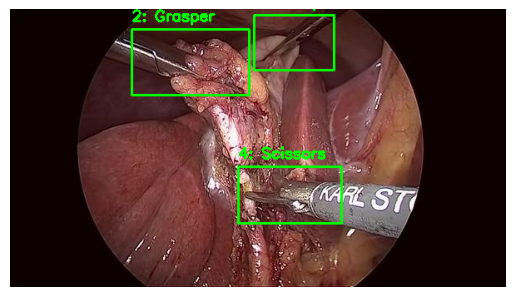

In [16]:
import os
import cv2
import matplotlib.pyplot as plt

image_dir = 'datasets/cars_license_plate_new/train/images'
label_dir = 'datasets/cars_license_plate_new/train/labels'

# Class ID to name dictionary (optional, can be used if you want to show class names)
class_dict = {
    0: "Bipolar",
    1: "SpecimenBag",
    2: "Grasper",
    3: "Irrigator",
    4: "Scissors",
    5: "Hook",
    6: "Clipper"
}

image_files = sorted(os.listdir(image_dir))
first_image_file = image_files[30]

image_path = os.path.join(image_dir, first_image_file)
label_path = os.path.join(label_dir, os.path.splitext(first_image_file)[0] + '.txt')

image = cv2.imread(image_path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
img_height, img_width, _ = image.shape

# Read YOLO label file
with open(label_path, 'r') as f:
    lines = f.readlines()

# Draw bounding boxes and class IDs
for line in lines:
    class_id, x_center, y_center, width, height = map(float, line.strip().split())

    x_center *= img_width
    y_center *= img_height
    width *= img_width
    height *= img_height

    x1 = int(x_center - width / 2)
    y1 = int(y_center - height / 2)
    x2 = int(x_center + width / 2)
    y2 = int(y_center + height / 2)

    cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Display class ID or class name
    label = f"{int(class_id)}: {class_dict.get(int(class_id), 'Unknown')}"
    cv2.putText(image, label, (x1, y1 - 10), cv2.FONT_HERSHEY_SIMPLEX, 0.6, (0, 255, 0), 2)

# Show image with boxes
plt.imshow(image)
plt.axis('off')
plt.show()


In [17]:
datasets_yaml = '''
path: cars_license_plate_new

train: train/images
val: val/images
test: test/images

# number of classes
nc: 7

# class names
names:
  - Bipolar
  - SpecimenBag
  - Grasper
  - Irrigator
  - Scissors
  - Hook
  - Clipper
'''

# Write the content to the datasets.yaml file
with open('datasets.yaml', 'w') as file:
    file.write(datasets_yaml)


from ultralytics import YOLO

model = YOLO('yolo12s.pt')

Creating new Ultralytics Settings v0.0.6 file ✅ 
View Ultralytics Settings with 'yolo settings' or at '/root/.config/Ultralytics/settings.json'
Update Settings with 'yolo settings key=value', i.e. 'yolo settings runs_dir=path/to/dir'. For help see https://docs.ultralytics.com/quickstart/#ultralytics-settings.


100%|██████████| 18.1M/18.1M [00:00<00:00, 115MB/s] 


In [18]:
os.environ['WANDB_MODE'] = 'offline'

In [19]:
model.train(
    data='datasets.yaml',  
    epochs=100,            
    batch=16,              
    device='cuda',         
    imgsz=640,  # Image size (width and height) for training           
    cache=True             
)

Ultralytics 8.3.130 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
engine/trainer: agnostic_nms=False, amp=True, augment=False, auto_augment=randaugment, batch=16, bgr=0.0, box=7.5, cache=True, cfg=None, classes=None, close_mosaic=10, cls=0.5, conf=None, copy_paste=0.0, copy_paste_mode=flip, cos_lr=False, cutmix=0.0, data=datasets.yaml, degrees=0.0, deterministic=True, device=0, dfl=1.5, dnn=False, dropout=0.0, dynamic=False, embed=None, epochs=100, erasing=0.4, exist_ok=False, fliplr=0.5, flipud=0.0, format=torchscript, fraction=1.0, freeze=None, half=False, hsv_h=0.015, hsv_s=0.7, hsv_v=0.4, imgsz=640, int8=False, iou=0.7, keras=False, kobj=1.0, line_width=None, lr0=0.01, lrf=0.01, mask_ratio=4, max_det=300, mixup=0.0, mode=train, model=yolo12s.pt, momentum=0.937, mosaic=1.0, multi_scale=False, name=train, nbs=64, nms=False, opset=None, optimize=False, optimizer=auto, overlap_mask=True, patience=100, perspective=0.0, plots=True, pose=12.0, pretrained=True, profile=False, pr

100%|██████████| 755k/755k [00:00<00:00, 17.6MB/s]


Overriding model.yaml nc=80 with nc=7

                   from  n    params  module                                       arguments                     
  0                  -1  1       928  ultralytics.nn.modules.conv.Conv             [3, 32, 3, 2]                 
  1                  -1  1     18560  ultralytics.nn.modules.conv.Conv             [32, 64, 3, 2]                
  2                  -1  1     26080  ultralytics.nn.modules.block.C3k2            [64, 128, 1, False, 0.25]     
  3                  -1  1    147712  ultralytics.nn.modules.conv.Conv             [128, 128, 3, 2]              
  4                  -1  1    103360  ultralytics.nn.modules.block.C3k2            [128, 256, 1, False, 0.25]    
  5                  -1  1    590336  ultralytics.nn.modules.conv.Conv             [256, 256, 3, 2]              
  6                  -1  2    689408  ultralytics.nn.modules.block.A2C2f           [256, 256, 2, True, 4]        
  7                  -1  1   1180672  ultralytics

100%|██████████| 5.35M/5.35M [00:00<00:00, 72.9MB/s]


AMP: checks passed ✅
train: Fast image access ✅ (ping: 0.0±0.0 ms, read: 736.3±233.3 MB/s, size: 24.8 KB)


train: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels... 1405 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1405/1405 [00:00<00:00, 1462.42it/s]

train: New cache created: /kaggle/working/datasets/cars_license_plate_new/train/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


train: Caching images (0.9GB RAM): 100%|██████████| 1405/1405 [00:01<00:00, 758.21it/s]


albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 453.8±151.9 MB/s, size: 24.2 KB)


val: Scanning /kaggle/working/datasets/cars_license_plate_new/val/labels... 843 images, 0 backgrounds, 0 corrupt: 100%|██████████| 843/843 [00:00<00:00, 1307.85it/s]

val: New cache created: /kaggle/working/datasets/cars_license_plate_new/val/labels.cache


WARNING ⚠️ cache='ram' may produce non-deterministic training results. Consider cache='disk' as a deterministic alternative if your disk space allows.


val: Caching images (0.5GB RAM): 100%|██████████| 843/843 [00:00<00:00, 944.69it/s]


Plotting labels to runs/detect/train/labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: AdamW(lr=0.000909, momentum=0.9) with parameter groups 113 weight(decay=0.0), 120 weight(decay=0.0005), 119 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 2 dataloader workers
Logging results to runs/detect/train
Starting training for 100 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/100      6.56G       1.83      3.771       1.91         41        640: 100%|██████████| 88/88 [00:38<00:00,  2.31it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.60it/s]

                   all        843       1176      0.602      0.551      0.565      0.281



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/100      6.76G      1.757      1.972      1.799         43        640: 100%|██████████| 88/88 [00:35<00:00,  2.46it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.39it/s]


                   all        843       1176      0.517      0.568      0.522      0.243

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/100      6.78G       1.77      1.822      1.816         36        640: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.32it/s]


                   all        843       1176      0.632      0.457      0.526      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/100      6.78G      1.739      1.728      1.805         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.42it/s]


                   all        843       1176      0.526      0.556       0.54      0.237

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/100      6.78G      1.716      1.579      1.785         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.44it/s]

                   all        843       1176      0.598      0.568      0.603      0.275



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/100      6.78G      1.693      1.489      1.746         29        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.42it/s]

                   all        843       1176      0.736       0.73      0.773      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/100      6.78G      1.648      1.429      1.711         36        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.728      0.692      0.714      0.327



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/100      6.78G      1.624      1.367      1.695         62        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.44it/s]

                   all        843       1176      0.695      0.724       0.76      0.383



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/100      6.78G      1.575      1.292      1.665         36        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.49it/s]

                   all        843       1176       0.78      0.718      0.791      0.395



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/100      6.78G      1.542       1.25      1.629         36        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176       0.83      0.764      0.842      0.449



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/100      6.78G      1.573      1.216      1.654         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.49it/s]

                   all        843       1176        0.8      0.748      0.809      0.425



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/100      6.78G      1.561      1.184       1.65         54        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.49it/s]

                   all        843       1176      0.842       0.78      0.865      0.463



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/100      6.78G      1.533      1.148       1.63         31        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176       0.85       0.79      0.877      0.472



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/100      6.78G      1.536      1.135      1.611         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.805      0.782      0.854      0.448



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/100      6.78G      1.494      1.106      1.598         37        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.47it/s]

                   all        843       1176      0.867      0.784       0.87      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/100      6.78G      1.469      1.061      1.571         34        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.48it/s]

                   all        843       1176      0.859      0.801      0.871      0.488



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/100      6.78G      1.462      1.003      1.555         52        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176      0.892      0.836      0.904      0.514



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/100      6.78G      1.424     0.9977      1.539         33        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.888      0.804      0.897      0.517



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/100      6.78G      1.451      1.015      1.567         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.46it/s]

                   all        843       1176       0.81      0.782      0.845      0.454



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/100      6.78G      1.433     0.9682       1.54         51        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.869      0.833      0.912      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/100      6.78G      1.422     0.9745       1.54         41        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.882      0.848      0.915      0.527



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/100      6.78G      1.393     0.9584      1.532         47        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.876      0.792       0.88      0.485



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/100      6.78G      1.375     0.9337      1.508         33        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.886      0.844      0.922      0.525



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/100      6.78G       1.38     0.9223      1.516         37        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.50it/s]

                   all        843       1176      0.891      0.863      0.919       0.52



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/100      6.78G      1.344     0.9013       1.49         40        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.49it/s]

                   all        843       1176      0.885      0.854      0.906      0.506



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/100      6.78G      1.365      0.884      1.496         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.903      0.841      0.919      0.526



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/100      6.78G      1.332     0.8601      1.464         44        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.886      0.874      0.927      0.532



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/100      6.78G      1.311      0.838      1.453         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.892      0.849      0.911      0.534



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/100      6.78G      1.325     0.8458      1.465         47        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.902      0.868      0.931      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/100      6.78G      1.281     0.8158      1.449         34        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.902      0.879       0.93      0.544



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/100      6.78G      1.302     0.8279      1.443         31        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.919      0.875      0.934      0.539



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/100      6.78G      1.282     0.7878      1.438         49        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.904      0.857       0.92      0.513



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/100      6.78G      1.278     0.7984      1.427         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176      0.912      0.879      0.934      0.552



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/100      6.78G      1.252     0.7905      1.423         52        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176       0.92      0.858      0.934      0.551



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/100      6.78G      1.252     0.7772      1.425         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.50it/s]

                   all        843       1176      0.941      0.875      0.942      0.559



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/100      6.78G      1.255     0.7767      1.407         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.50it/s]

                   all        843       1176      0.925      0.874      0.942      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/100      6.78G      1.234     0.7351      1.401         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.47it/s]

                   all        843       1176      0.925      0.888       0.94      0.565



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/100      6.78G      1.225     0.7335      1.403         30        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.928      0.868      0.935      0.554



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/100      6.78G      1.223     0.7303      1.407         47        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.922      0.827      0.912      0.536



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/100      6.78G      1.205     0.7271      1.388         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176        0.9      0.876      0.932      0.562



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/100      6.78G      1.209     0.7306      1.382         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176      0.931      0.887      0.944      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/100      6.78G      1.173     0.7223       1.36         26        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.47it/s]

                   all        843       1176      0.926       0.88      0.941      0.567



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/100      6.78G      1.178     0.7002      1.353         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176      0.925      0.875       0.94      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/100      6.78G       1.14     0.6763      1.334         44        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.916      0.872      0.944      0.571



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/100      6.78G      1.159     0.6796       1.35         31        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.914      0.874      0.937      0.569



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/100      6.78G      1.139     0.6808      1.336         37        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.59it/s]

                   all        843       1176      0.924      0.876       0.94      0.573



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/100      6.78G       1.13     0.6745      1.333         31        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.918      0.884      0.946      0.575



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/100      6.78G      1.111      0.651      1.317         40        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176       0.93      0.899      0.953       0.57



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/100      6.78G      1.122      0.663      1.314         46        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.935      0.889      0.947      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/100      6.78G      1.119     0.6569      1.318         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.50it/s]

                   all        843       1176      0.925      0.892      0.949      0.581



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/100      6.78G      1.088     0.6261       1.29         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176       0.93      0.887      0.947      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/100      6.78G      1.083     0.6216      1.296         30        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.943      0.896      0.949      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/100      6.78G      1.073     0.6138      1.282         37        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.922      0.898      0.945      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/100      6.78G      1.057     0.6059      1.266         47        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.934      0.866      0.937      0.582



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/100      6.78G      1.067     0.6077      1.285         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.921      0.903      0.951      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/100      6.78G      1.044     0.5947      1.269         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.916      0.904      0.949      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/100      6.78G      1.036     0.5906      1.262         31        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.923      0.908      0.953      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/100      6.78G      1.023     0.5741      1.246         30        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.59it/s]

                   all        843       1176       0.92      0.909      0.947      0.583



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/100      6.78G      1.012     0.5822      1.245         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.924      0.915      0.952      0.591



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/100      6.78G      1.022     0.5837      1.248         46        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.937      0.887      0.948      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/100      6.78G      1.013     0.5711      1.243         34        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.59it/s]

                   all        843       1176      0.925      0.904      0.947      0.585



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/100      6.78G     0.9886     0.5489      1.231         33        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176       0.91      0.905      0.944      0.587



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/100      6.78G     0.9853     0.5564      1.236         37        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.923      0.904      0.948      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/100      6.78G     0.9595     0.5376      1.218         27        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.931      0.902      0.952      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/100      6.78G     0.9634      0.534      1.205         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.944      0.887      0.951        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/100      6.78G     0.9356      0.528       1.18         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.59it/s]

                   all        843       1176      0.923      0.909      0.946      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/100      6.78G     0.9389     0.5383        1.2         32        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.934      0.899      0.941      0.586



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/100      6.78G     0.9276     0.5183      1.182         27        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.931      0.913      0.948      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/100      6.78G     0.9205     0.5221      1.197         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.60it/s]

                   all        843       1176       0.92      0.901      0.946      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/100      6.78G     0.9422     0.5255      1.195         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.931      0.888      0.948      0.595



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/100      6.78G     0.9121     0.5072      1.173         40        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.937      0.897      0.954        0.6



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/100      6.78G     0.8909     0.5029      1.162         33        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.59it/s]

                   all        843       1176      0.931      0.897      0.948      0.593



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/100      6.78G     0.9011     0.5106       1.17         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.37it/s]

                   all        843       1176      0.935      0.899      0.954      0.594



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/100      6.78G     0.8972      0.509      1.169         35        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.917      0.903      0.947      0.599



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/100      6.78G      0.883     0.4852      1.153         36        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.927      0.907      0.946      0.596



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/100      6.78G     0.8667     0.4965      1.154         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.938      0.889      0.949      0.601



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/100      6.78G     0.8684     0.4984      1.155         45        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.61it/s]

                   all        843       1176      0.936      0.903      0.953      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/100      6.78G     0.8515     0.4789      1.143         30        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.60it/s]

                   all        843       1176      0.946      0.884      0.951      0.602



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/100      6.78G     0.8504     0.4769      1.144         40        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.57it/s]

                   all        843       1176      0.937      0.898      0.951      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/100      6.78G     0.8293     0.4734      1.135         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.918      0.907      0.951      0.605



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/100      6.78G     0.8343     0.4701      1.132         46        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.53it/s]

                   all        843       1176      0.947      0.888      0.951      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/100      6.78G     0.8071     0.4688      1.123         34        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.936        0.9      0.955      0.604



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/100      6.78G     0.8122     0.4679      1.122         30        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.55it/s]

                   all        843       1176      0.926      0.916      0.953      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/100      6.78G     0.8177     0.4702      1.121         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.921       0.91      0.952      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/100      6.78G     0.7939      0.458      1.108         38        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.942      0.902      0.953      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/100      6.78G     0.7838     0.4488      1.097         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.943      0.899      0.956      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/100      6.78G     0.7739      0.437      1.092         39        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.63it/s]

                   all        843       1176      0.931        0.9      0.955      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/100      6.78G     0.7596     0.4344      1.091         42        640: 100%|██████████| 88/88 [00:36<00:00,  2.40it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.58it/s]

                   all        843       1176      0.921      0.906      0.951      0.612



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/100      6.78G     0.7752     0.4342      1.091         43        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.921      0.917      0.952      0.611



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/100      6.78G     0.7594      0.438      1.087         41        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:06<00:00,  4.47it/s]

                   all        843       1176      0.934      0.902      0.951       0.61


Closing dataloader mosaic
albumentations: ImageCompression.__init__() got an unexpected keyword argument 'quality_range'

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/100      6.78G     0.6888     0.3213       1.07         19        640: 100%|██████████| 88/88 [00:36<00:00,  2.39it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.54it/s]

                   all        843       1176      0.937      0.906      0.947      0.597



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/100      6.78G     0.6491     0.3033      1.044         20        640: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.937       0.91      0.952       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/100      6.78G     0.6315     0.2961       1.03         20        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.938      0.907      0.951      0.609



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/100      6.78G     0.6257     0.2885      1.033         18        640: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.58it/s]

                   all        843       1176      0.927      0.916      0.953      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/100      6.78G     0.6205     0.2889      1.028         16        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.58it/s]

                   all        843       1176      0.933      0.908      0.951      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/100      6.78G     0.6067      0.284       1.01         19        640: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.927      0.914      0.952      0.606



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/100      6.78G     0.6028     0.2837       1.02         20        640: 100%|██████████| 88/88 [00:36<00:00,  2.42it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.56it/s]

                   all        843       1176      0.943      0.894      0.954       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/100      6.78G     0.5936     0.2818      1.012         19        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.52it/s]

                   all        843       1176      0.932      0.906      0.952       0.61



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/100      6.78G     0.5861     0.2745     0.9987         21        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.51it/s]

                   all        843       1176      0.933      0.905      0.955      0.608



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/100      6.78G       0.57     0.2726     0.9943         24        640: 100%|██████████| 88/88 [00:36<00:00,  2.41it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:05<00:00,  4.58it/s]

                   all        843       1176      0.929      0.904      0.953      0.611



100 epochs completed in 1.197 hours.
Optimizer stripped from runs/detect/train/weights/last.pt, 18.9MB
Optimizer stripped from runs/detect/train/weights/best.pt, 18.9MB

Validating runs/detect/train/weights/best.pt...
Ultralytics 8.3.130 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,233,589 parameters, 0 gradients, 21.2 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 27/27 [00:07<00:00,  3.51it/s]


                   all        843       1176      0.922      0.917      0.953      0.611
               Bipolar        140        140      0.931      0.943      0.958      0.621
           SpecimenBag        139        139      0.947      0.928      0.958      0.634
               Grasper        340        422      0.869      0.877      0.919      0.555
             Irrigator        173        173      0.914      0.931      0.953      0.463
              Scissors        107        107      0.898      0.907      0.943      0.645
                  Hook         79         79      0.935      0.906      0.974        0.7
               Clipper        116        116      0.956      0.927      0.962      0.661
Speed: 0.1ms preprocess, 3.7ms inference, 0.0ms loss, 1.1ms postprocess per image
Results saved to runs/detect/train


ultralytics.utils.metrics.DetMetrics object with attributes:

ap_class_index: array([0, 1, 2, 3, 4, 5, 6])
box: ultralytics.utils.metrics.Metric object
confusion_matrix: <ultralytics.utils.metrics.ConfusionMatrix object at 0x783bf1555450>
curves: ['Precision-Recall(B)', 'F1-Confidence(B)', 'Precision-Confidence(B)', 'Recall-Confidence(B)']
curves_results: [[array([          0,    0.001001,    0.002002,    0.003003,    0.004004,    0.005005,    0.006006,    0.007007,    0.008008,    0.009009,     0.01001,    0.011011,    0.012012,    0.013013,    0.014014,    0.015015,    0.016016,    0.017017,    0.018018,    0.019019,     0.02002,    0.021021,    0.022022,    0.023023,
          0.024024,    0.025025,    0.026026,    0.027027,    0.028028,    0.029029,     0.03003,    0.031031,    0.032032,    0.033033,    0.034034,    0.035035,    0.036036,    0.037037,    0.038038,    0.039039,     0.04004,    0.041041,    0.042042,    0.043043,    0.044044,    0.045045,    0.046046,    0.047047,
  

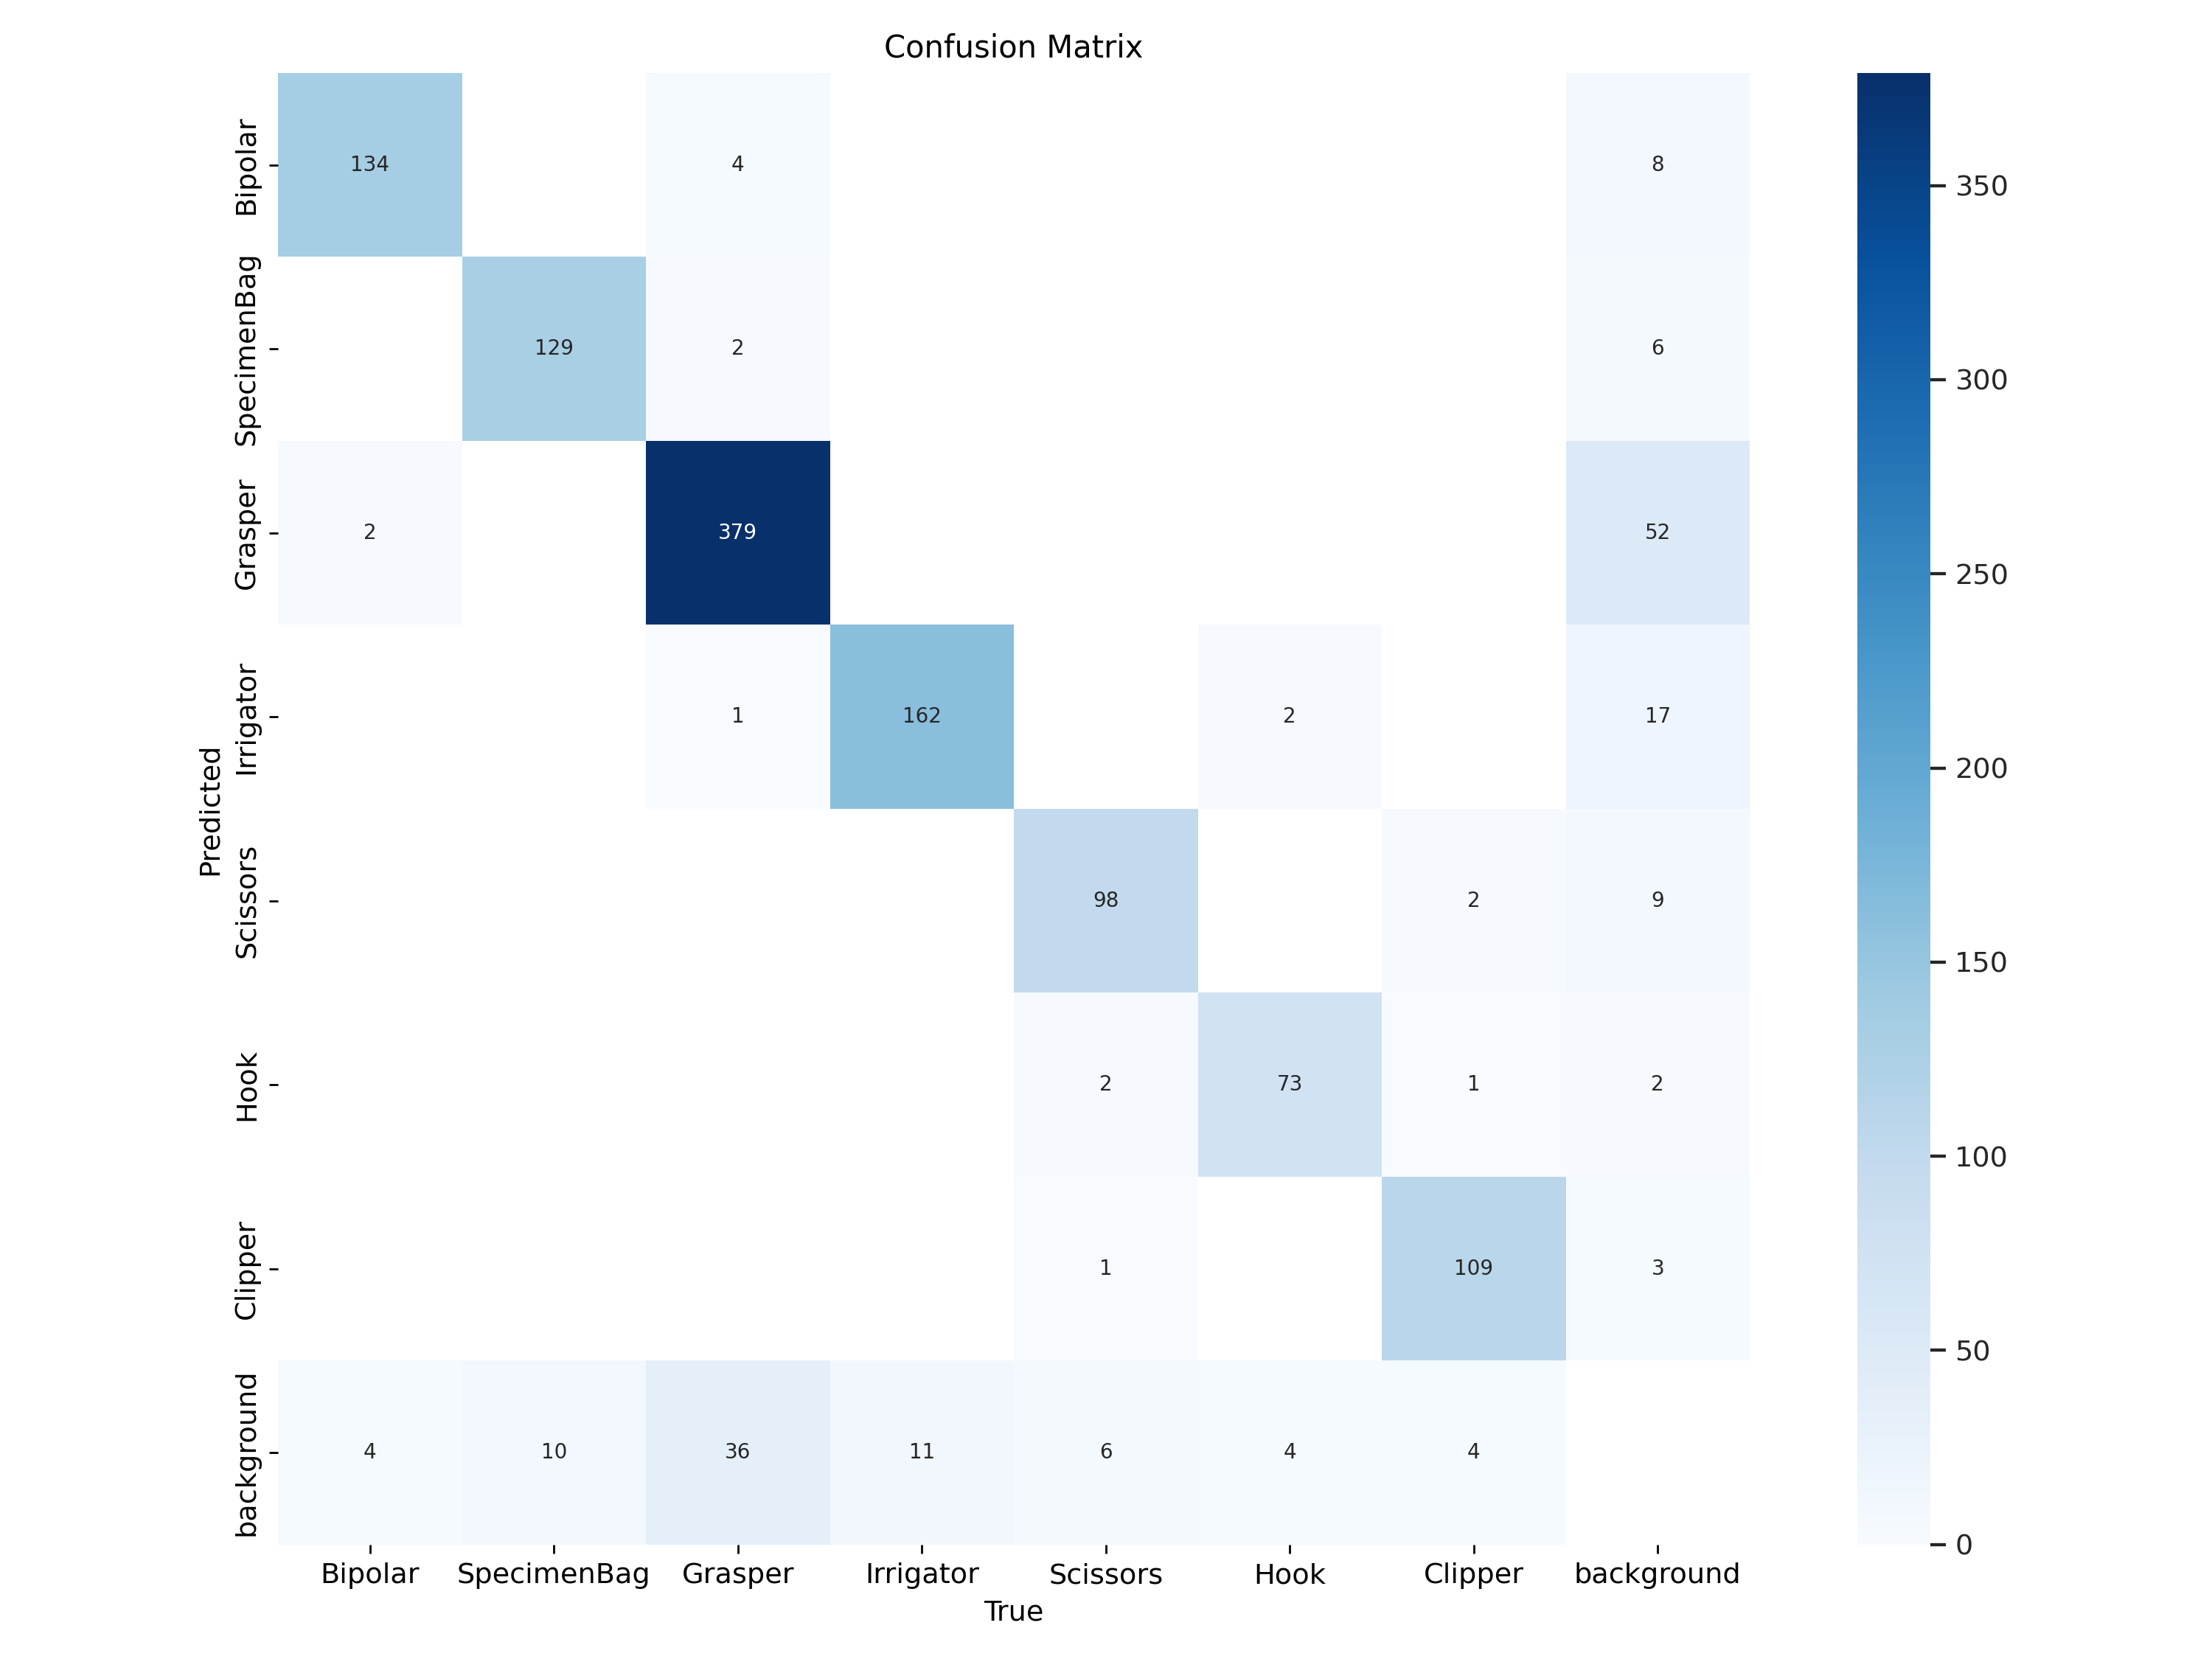

In [20]:
from IPython.display import Image
Image(filename='/kaggle/working//runs/detect/train/confusion_matrix.png', width=1000)

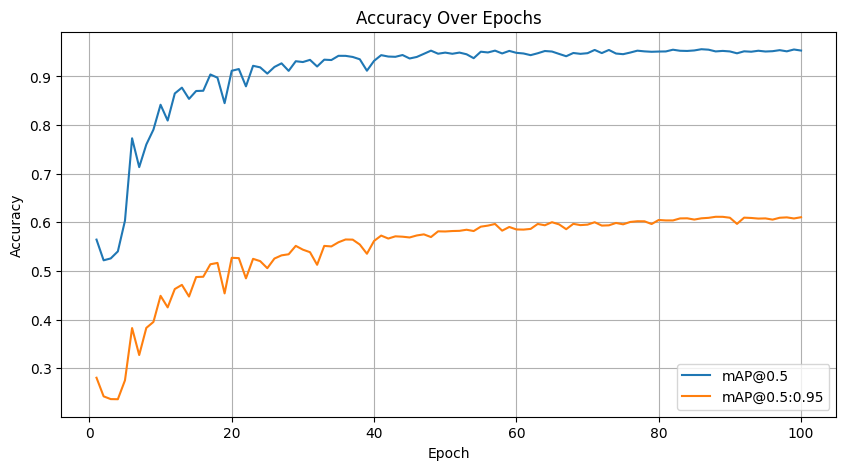

In [21]:
# Find recent training log dir
log_dir = max(glob('runs/detect/train*'), key=the_number_in_the_string)

results = pd.read_csv(os.path.join(log_dir, 'results.csv'))
results.columns = results.columns.str.strip()

epochs = results.index + 1 
mAP_0_5 = results['metrics/mAP50(B)'] 
mAP_0_5_0_95 = results['metrics/mAP50-95(B)']

plt.figure(figsize=(10, 5))
plt.plot(epochs, mAP_0_5, label='mAP@0.5')
plt.plot(epochs, mAP_0_5_0_95, label='mAP@0.5:0.95')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy Over Epochs')
plt.legend()
plt.grid(True)
plt.show()

In [22]:
# save model
model.save('license_plate_model_sauravdb.pt')

# Test and predictions

In [23]:
# to predict test image
def predict_and_plot(path_test_car):
   
    results = model.predict(path_test_car, device='cpu')

    image = cv2.imread(path_test_car)
    
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

    
    for result in results:
        for box in result.boxes:
            
            x1, y1, x2, y2 = map(int, box.xyxy[0])
            confidence = box.conf[0]

            cv2.rectangle(image, (x1, y1), (x2, y2), (0, 255, 0), 2)
            
            cv2.putText(image, f'{confidence*100:.2f}%', (x1, y1 - 10), 
                        cv2.FONT_HERSHEY_SIMPLEX, 0.9, (255, 0, 0), 2)

    
    plt.imshow(image)
    plt.axis('off')  
    plt.show()  


image 1/1 /kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/JPEGImages/v10_019950.jpg: 384x640 1 Clipper, 219.0ms
Speed: 1.9ms preprocess, 219.0ms inference, 19.6ms postprocess per image at shape (1, 3, 384, 640)


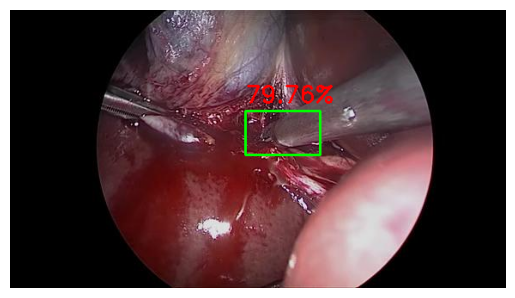

In [24]:
predict_and_plot(test.iloc[0].img_path)


image 1/1 /kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/JPEGImages/v05_055600.jpg: 384x640 1 SpecimenBag, 166.7ms
Speed: 1.8ms preprocess, 166.7ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


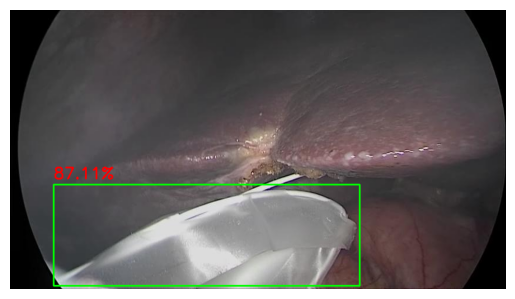

In [25]:
predict_and_plot(test.iloc[2].img_path)


image 1/1 /kaggle/input/surgerical-tools/m2cai16-tool-locations/m2cai16-tool-locations/JPEGImages/v07_015450.jpg: 384x640 1 Irrigator, 155.4ms
Speed: 1.8ms preprocess, 155.4ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)


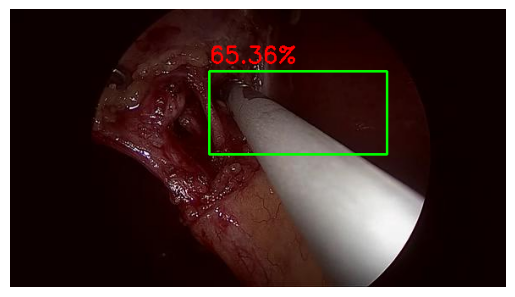

In [26]:
predict_and_plot(test.iloc[4].img_path)

In [27]:
from ultralytics import YOLO

# Load the trained model (adjust the path to your best weights)
model = YOLO('/kaggle/working/runs/detect/train/weights/best.pt')

# Evaluate the model on the test set
metrics = model.val(data='datasets.yaml', split='train')


Ultralytics 8.3.130 🚀 Python-3.10.13 torch-2.1.2 CUDA:0 (Tesla T4, 15095MiB)
YOLOv12s summary (fused): 159 layers, 9,233,589 parameters, 0 gradients, 21.2 GFLOPs
val: Fast image access ✅ (ping: 0.0±0.0 ms, read: 1071.2±320.5 MB/s, size: 32.6 KB)


val: Scanning /kaggle/working/datasets/cars_license_plate_new/train/labels.cache... 1405 images, 0 backgrounds, 0 corrupt: 100%|██████████| 1405/1405 [00:00<?, ?it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 88/88 [00:16<00:00,  5.42it/s]


                   all       1405       1973      0.996      0.998      0.995       0.89
               Bipolar        215        215      0.991      0.994      0.995      0.893
           SpecimenBag        241        241          1      0.995      0.995      0.908
               Grasper        562        707      0.992      0.997      0.995      0.863
             Irrigator        228        228          1          1      0.995      0.853
              Scissors        197        197      0.995          1      0.995      0.866
                  Hook        165        165      0.997          1      0.995      0.931
               Clipper        220        220      0.998          1      0.995      0.915
Speed: 0.3ms preprocess, 7.6ms inference, 0.0ms loss, 1.2ms postprocess per image
Results saved to runs/detect/val


In [28]:
pip install supervision

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 181.5/181.5 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [29]:
import time
import cv2
import supervision as sv
from ultralytics import YOLO
from tqdm import tqdm

def detect_and_annotate_video(input_path: str, output_path: str, model_path: str):
    model = YOLO(model_path)

    cap = cv2.VideoCapture(input_path)
    if not cap.isOpened():
        raise ValueError(f"Could not open video file: {input_path}")

    frame_count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))
    fps = cap.get(cv2.CAP_PROP_FPS)
    width = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    height = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    fourcc = cv2.VideoWriter_fourcc(*'mp4v')
    out = cv2.VideoWriter(output_path, fourcc, fps, (width, height))

    box_annotator = sv.BoxAnnotator()
    label_annotator = sv.LabelAnnotator()

    total_inference_time = 0
    processed_frames = 0

    with tqdm(total=frame_count, desc="Processing video") as pbar:
        while True:
            ret, frame = cap.read()
            if not ret:
                break

            start_time = time.time()

            results = model(frame, verbose=False)[0]
            detections = sv.Detections.from_ultralytics(results).with_nms()

            annotated_frame = frame.copy()
            annotated_frame = box_annotator.annotate(scene=annotated_frame, detections=detections)
            annotated_frame = label_annotator.annotate(scene=annotated_frame, detections=detections)

            inference_time = time.time() - start_time
            total_inference_time += inference_time
            processed_frames += 1

            out.write(annotated_frame)
            pbar.update(1)

    cap.release()
    out.release()

    avg_fps = processed_frames / total_inference_time if total_inference_time > 0 else 0
    print(f"Annotated video saved to {output_path}")
    print(f"Processed {processed_frames} frames in {total_inference_time:.2f} seconds — Avg FPS: {avg_fps:.2f}")


In [30]:
detect_and_annotate_video('/kaggle/input/yolo12-wts/video36.mp4','detected.mp4','/kaggle/working/runs/detect/train/weights/best.pt')

Processing video: 100%|██████████| 59676/59676 [20:56<00:00, 47.49it/s]


Annotated video saved to detected.mp4
Processed 59676 frames in 1014.71 seconds — Avg FPS: 58.81
